<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/main/notebooks/vidi/best_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Fully Convolutional Network for Crowd Counting

This notebook implements SFCN with VGG16-BN backbone for crowd counting tasks.

**Features:**
- VGG16-BN backbone with spatial encoder
- Adaptive density map generation with KNN-based sigma
- Advanced data augmentation with patch-based training
- Mixed precision training with gradient accumulation
- Early stopping and model checkpointing
- Optional empty patch avoidance for better training

# Import Libraries

In [1]:
# Import Required Libraries and Setup
import os
import re
import json
import math
import random
import argparse
import warnings
from glob import glob
from typing import List, Tuple
import sys
import platform

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

# Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print("✅ All libraries imported successfully!")


# Detect environment
def detect_environment():
    """Detect if running in Colab, Kaggle, or local environment"""
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle_secrets' in sys.modules or os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
        return 'kaggle'
    else:
        return 'local'

ENV = detect_environment()
print(f"🔍 Detected environment: {ENV.upper()}")


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All libraries imported successfully!
🔍 Detected environment: COLAB
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 15.8 GB


# Dataset Download and Setup

In [2]:
# Environment-specific dataset setup
def setup_dataset_paths(env: str) -> dict[str, str]:
    """Setup dataset paths based on environment"""

    if env == 'colab':
        # Google Colab paths
        dataset_name = "penyisihan-hology-8-0-2025-data-mining"
        drive_path = "/content/drive/MyDrive/PROJECTS/Cognivio/dataset"
        local_path = "/content/dataset"

        # Download and setup dataset in Colab
        if not os.path.exists(local_path):
            print("📥 Setting up dataset in Colab...")

            # Check for kaggle.json in Drive first
            kaggle_json_drive = "/content/drive/MyDrive/kaggle.json"
            kaggle_json_local = "/root/.kaggle/kaggle.json"

            if os.path.exists(kaggle_json_drive):
                print('copy from drive')
                # Copy from Drive
                !mkdir -p /root/.kaggle
                !cp "{kaggle_json_drive}" "{kaggle_json_local}"
                !chmod 600 "{kaggle_json_local}"
                print("✅ Kaggle credentials loaded from Drive")
            else:
                print("⚠️  Please upload kaggle.json to your Google Drive root folder")
                print("   Or manually upload it when prompted below")
                from google.colab import files
                uploaded = files.upload()
                for fn in uploaded.keys():
                    !mkdir -p /root/.kaggle
                    !mv "{fn}" "/root/.kaggle/kaggle.json"
                    !chmod 600 "/root/.kaggle/kaggle.json"
                    print(f"✅ Kaggle credentials uploaded: {fn}")

            # Download dataset
            !kaggle competitions download -c {dataset_name} -p /content

            # Extract dataset
            import zipfile
            zip_path = f"/content/{dataset_name}.zip"
            if os.path.exists(zip_path):
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(local_path)
                print(f"✅ Dataset extracted to {local_path}")
            else:
                raise FileNotFoundError(f"Dataset zip not found: {zip_path}")

        return {
            'img_dir': f"{local_path}/train/images",
            'label_dir': f"{local_path}/train/labels",
            'test_dir': f"{local_path}/test/images",
            'save_dir': "/content/drive/MyDrive/PROJECTS/Cognivio/models"
        }

    elif env == 'kaggle':
        # Kaggle paths
        return {
            'img_dir': "/kaggle/input/penyisihan-hology-8-0-2025-data-mining/train/images",
            'label_dir': "/kaggle/input/penyisihan-hology-8-0-2025-data-mining/train/labels",
            'test_dir': "/kaggle/input/penyisihan-hology-8-0-2025-data-mining/test/images",
            'save_dir': "/kaggle/working"
        }

    else:  # local
        # Local paths - modify these for your setup
        base_path = "data"  # Change this to your local dataset path
        return {
            'img_dir': f"{base_path}/train/images",
            'label_dir': f"{base_path}/train/labels",
            'test_dir': f"{base_path}/test/images",
            'save_dir': "models"
        }

# Setup paths
paths = setup_dataset_paths(ENV)
print(f"📁 Dataset paths configured for {ENV}:")
for key, path in paths.items():
    exists = "✅" if os.path.exists(path) else "⚠️"
    print(f"   {key}: {path} {exists}")

# Create save directory
os.makedirs(paths['save_dir'], exist_ok=True)

📥 Setting up dataset in Colab...
⚠️  Please upload kaggle.json to your Google Drive root folder
   Or manually upload it when prompted below


Saving kaggle.json to kaggle.json
✅ Kaggle credentials uploaded: kaggle.json
 70% 147M/209M [00:00<00:00, 1.53GB/s]
100% 209M/209M [00:00<00:00, 998MB/s] 
✅ Dataset extracted to /content/dataset
📁 Dataset paths configured for colab:
   img_dir: /content/dataset/train/images ✅
   label_dir: /content/dataset/train/labels ✅
   test_dir: /content/dataset/test/images ✅
   save_dir: /content/drive/MyDrive/PROJECTS/Cognivio/models ⚠️


# Training Configuration

In [3]:
# Training Configuration
config = {
    # Data paths (modify these for local setup)
    'img_dir': paths['img_dir'],
    'label_dir': paths['label_dir'],
    'test_dir': paths['test_dir'],
    'save_dir': paths['save_dir'],

    # Model parameters
    'base_size': 1024,
    'down': 8,
    'patch_size': 384,
    'patches_per_image': 4,
    'avoid_empty_patches': True,

    # Training parameters
    'batch_size': 12, # (default=12, testing=4) change to higher in high computational environment
    'epochs': 120,  # (default=120, testing=2) Increase for full training
    'lr': 2e-4, # or 1e-4
    'criterion': 'mse',  # 'mse' or 'huber'
    'count_loss_alpha': 0.0,  # Auxiliary count loss weight
    'early_stop_patience': 15,

    # Optimization
    'num_workers': 4, # change to higher in high computational environment
    'amp': True,  # Automatic Mixed Precision
    'accum_steps': 2,  # Gradient accumulation steps

    # Augmentation and preprocessing
    'sigma_mode': 'adaptive',  # 'adaptive' or 'constant'

    # Model saving
    'save_path': os.path.join(paths['save_dir'], 'sfcn_best.pth'),
    'seed': 1337
}

print("📋 Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Set random seed for reproducibility
def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(config['seed'])
print(f"🎲 Random seed set to {config['seed']}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

📋 Configuration loaded:
  img_dir: /content/dataset/train/images
  label_dir: /content/dataset/train/labels
  test_dir: /content/dataset/test/images
  save_dir: /content/drive/MyDrive/PROJECTS/Cognivio/models
  base_size: 1024
  down: 8
  patch_size: 384
  patches_per_image: 4
  avoid_empty_patches: True
  batch_size: 12
  epochs: 120
  lr: 0.0002
  criterion: mse
  count_loss_alpha: 0.0
  early_stop_patience: 15
  num_workers: 4
  amp: True
  accum_steps: 2
  sigma_mode: adaptive
  save_path: /content/drive/MyDrive/PROJECTS/Cognivio/models/sfcn_best.pth
  seed: 1337
🎲 Random seed set to 1337
🔧 Using device: cuda


# Utility Functions

In [4]:
def set_seed(
    seed: int = 1337
) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def imread_rgb(
    path: str
) -> np.ndarray:
    """Read an RGB image using OpenCV and convert BGR→RGB."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def letterbox(
    img: np.ndarray,
    target: int = 512
) -> Tuple[np.ndarray, float, int, int]:
    """Resize and pad an image to a square canvas without distortion.

    Returns the padded image, the scale factor used, and the left/top
    padding applied. The output size is (target, target).
    """
    h, w = img.shape[:2]
    scale = min(target / h, target / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    img_rs = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    top = (target - nh) // 2
    left = (target - nw) // 2
    canvas = np.zeros((target, target, 3), dtype=img_rs.dtype)
    canvas[top:top + nh, left:left + nw] = img_rs
    return canvas, scale, left, top

def parse_points_from_json(
    path: str
) -> Tuple[np.ndarray, int]:
    """Parse annotated points from a JSON file.

    Supports several common crowd counting annotation formats. Returns an
    array of shape (N, 2) containing [x, y] coordinates and, if present
    in the JSON, the declared number of people.
    """
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    pts: List[List[float]]
    num = None
    if isinstance(obj, dict) and "points" in obj:
        pts = obj["points"]
        num = obj.get("human_num", obj.get("num_human", None))
        if len(pts) > 0 and isinstance(pts[0], dict):
            pts = [[p["x"], p["y"]] for p in pts if "x" in p and "y" in p]
    elif isinstance(obj, dict) and "annotations" in obj:
        pts = [[a["x"], a["y"]] for a in obj["annotations"] if "x" in a and "y" in a]
        num = obj.get("human_num", obj.get("num_human", None))
    elif isinstance(obj, list):
        pts = obj
    else:
        raise ValueError(f"Unknown JSON schema: {path}")
    pts_arr = np.array(pts, dtype=np.float32) if len(pts) > 0 else np.zeros((0, 2), np.float32)
    return pts_arr, num

def derive_json_path(
    lbl_dir: str,
    img_path: str
) -> str:
    """Derive the corresponding JSON label path for a given image path."""
    name = os.path.splitext(os.path.basename(img_path))[0]
    cand = os.path.join(lbl_dir, name + ".json")
    if os.path.exists(cand):
        return cand
    # Try matching trailing digits
    m = re.findall(r"\d+", name)
    if m:
        alt = os.path.join(lbl_dir, f"{m[-1]}.json")
        if os.path.exists(alt):
            return alt
    # Fallback: any file starting with the same name
    lst = glob(os.path.join(lbl_dir, f"{name}*.json"))
    if lst:
        return lst[0]
    raise FileNotFoundError(f"JSON label not found for {img_path}")

def make_density_map(
    points_xy: np.ndarray,
    grid_size: int,
    down: int = 8,
    sigma_mode: str = "adaptive",
    knn: int = 3,
    beta: float = 0.3,
    const_sigma: float = 2.0,
) -> np.ndarray:
    """Generate a density map on a grid given annotated points.

    The density map is of shape (grid_size//down, grid_size//down). Each
    point is represented by a Gaussian whose sigma is either constant or
    computed from the k-nearest neighbours.
    """
    target = grid_size
    dh, dw = target // down, target // down
    den = np.zeros((dh, dw), dtype=np.float32)

    if len(points_xy) == 0:
        return den

    # Scale points to the density map resolution
    pts = points_xy.copy()
    pts[:, 0] = pts[:, 0] * (dw / target)
    pts[:, 1] = pts[:, 1] * (dh / target)
    tree = KDTree(pts) if len(pts) > 1 else None

    for (x, y) in pts:
        # Determine sigma
        if sigma_mode == "adaptive" and tree is not None and len(pts) > 3:
            dists, _ = tree.query([x, y], k=min(knn + 1, len(pts)))
            sigma = max(1.0, float(np.mean(dists[1:])) * beta)
        else:
            sigma = const_sigma

        cx, cy = float(x), float(y)
        rad = int(max(1, math.ceil(3 * sigma)))
        x0, x1 = max(0, int(math.floor(cx - rad))), min(dw, int(math.ceil(cx + rad + 1)))
        y0, y1 = max(0, int(math.floor(cy - rad))), min(dh, int(math.ceil(cy + rad + 1)))

        if x1 <= x0 or y1 <= y0:
            continue

        xs = np.arange(x0, x1) - cx
        ys = np.arange(y0, y1) - cy
        xx, yy = np.meshgrid(xs, ys)
        g = np.exp(-(xx**2 + yy**2) / (2 * sigma * sigma))
        s = g.sum()

        if s > 0:
            den[y0:y1, x0:x1] += (g / s).astype(np.float32)

    return den

print("✅ Basic utility functions defined!")

✅ Basic utility functions defined!


# Dataset Implementation

In [5]:
class CrowdDataset(Dataset):
    """Custom dataset for crowd counting.

    Supports optional random patch cropping on training data. When
    `avoid_empty_patches` is set, the dataset will attempt to choose a
    patch containing at least one point, falling back to a random crop if
    it fails after a number of retries.
    """

    def __init__(
        self,
        img_dir: str,
        lbl_dir: str,
        base_size: int = 768,
        down: int = 8,
        aug: bool = True,
        mode: str = "train",
        patch_size: int = 0,
        patches_per_image: int = 1,
        sigma_mode: str = "adaptive",
        avoid_empty_patches: bool = False,
    ) -> None:
        super().__init__()
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.*")))
        if len(self.img_paths) == 0:
            raise ValueError(f"No images found in {img_dir}")
        self.lbl_dir = lbl_dir
        self.base_size = base_size
        self.down = down
        self.aug = aug
        self.mode = mode
        self.patch_size = patch_size
        self.patches_per_image = max(1, int(patches_per_image))
        self.sigma_mode = sigma_mode
        self.avoid_empty_patches = avoid_empty_patches

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        self.color_jit = transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)

        # Compute effective length for patch training
        if self.mode == "train" and self.patch_size > 0 and self.patches_per_image > 1:
            self.effective_len = len(self.img_paths) * self.patches_per_image
        else:
            self.effective_len = len(self.img_paths)

    def __len__(self) -> int:
        return self.effective_len

    def _load_img_pts(
        self,
        idx_base: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Load an image and its transformed annotation points."""
        pimg = self.img_paths[idx_base]
        img = imread_rgb(pimg)
        h, w = img.shape[:2]
        plbl = derive_json_path(self.lbl_dir, pimg)
        pts, _ = parse_points_from_json(plbl)

        # Augment: horizontal flip
        if self.mode == "train" and self.aug and random.random() < 0.5:
            img = img[:, ::-1, :].copy()
            if len(pts) > 0:
                pts = pts.copy()
                pts[:, 0] = (w - 1) - pts[:, 0]

        # Augment: colour jitter
        if self.mode == "train" and self.aug and random.random() < 0.5:
            pil = transforms.ToPILImage()(img)
            pil = self.color_jit(pil)
            img = np.array(pil)

        # Letterbox to base size
        canvas, scale, left, top = letterbox(img, target=self.base_size)
        if len(pts) > 0:
            pts_tr = pts.copy()
            pts_tr[:, 0] = pts_tr[:, 0] * scale + left
            pts_tr[:, 1] = pts_tr[:, 1] * scale + top
            # Clamp to canvas bounds
            m = (
                (pts_tr[:, 0] >= 0)
                & (pts_tr[:, 0] < self.base_size)
                & (pts_tr[:, 1] >= 0)
                & (pts_tr[:, 1] < self.base_size)
            )
            pts_tr = pts_tr[m]
        else:
            pts_tr = np.zeros((0, 2), np.float32)
        return canvas, pts_tr

    def __getitem__(
        self,
        index: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Map global index to an image index (for patch training)
        if self.mode == "train" and self.patch_size > 0 and self.patches_per_image > 1:
            idx_base = index // self.patches_per_image
        else:
            idx_base = index
        idx_base %= len(self.img_paths)

        img_lb, pts_tr = self._load_img_pts(idx_base)

        # Optional patch cropping
        if self.mode == "train" and self.patch_size > 0:
            ps = self.patch_size
            if ps > self.base_size:
                raise ValueError("patch_size must be <= base_size")

            max_off = self.base_size - ps
            pts_out = np.zeros((0, 2), np.float32)

            # Attempt to find a non-empty patch when requested
            for attempt in range(10) if self.avoid_empty_patches else [0]:
                ox = 0 if max_off <= 0 else random.randint(0, max_off)
                oy = 0 if max_off <= 0 else random.randint(0, max_off)
                crop = img_lb[oy : oy + ps, ox : ox + ps, :]
                if len(pts_tr) > 0:
                    pts_c = pts_tr.copy()
                    pts_c[:, 0] -= ox
                    pts_c[:, 1] -= oy
                    m = (
                        (pts_c[:, 0] >= 0)
                        & (pts_c[:, 0] < ps)
                        & (pts_c[:, 1] >= 0)
                        & (pts_c[:, 1] < ps)
                    )
                    pts_c = pts_c[m]
                else:
                    pts_c = np.zeros((0, 2), np.float32)
                # If avoid_empty_patches is False, we break immediately (no retries)
                if not self.avoid_empty_patches or len(pts_c) > 0 or attempt == 9:
                    pts_out = pts_c
                    img_out = crop
                    break
            grid = ps
        else:
            img_out = img_lb
            pts_out = pts_tr
            grid = self.base_size

        # Build density map
        den = make_density_map(
            pts_out,
            grid_size=grid,
            down=self.down,
            sigma_mode=self.sigma_mode,
        )

        # Convert to tensors and normalise
        t = self.to_tensor(img_out)
        t = self.normalize(t)
        d = torch.from_numpy(den).unsqueeze(0)
        c = torch.tensor([float(len(pts_out))], dtype=torch.float32)
        return t, d, c

print("✅ CrowdDataset class implemented!")

✅ CrowdDataset class implemented!


# Model Architecture

In [6]:
class SpatialEncoder(nn.Module):
    """Simple spatial encoder that propagates information in four directions."""

    def __init__(
        self,
        channels: int,
        k: int = 9
    ) -> None:
        super().__init__()
        p = k // 2
        self.h1 = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(1, k),
            padding=(0, p),
            groups=channels,
            bias=False
        )
        self.h2 = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(1, k),
            padding=(0, p),
            groups=channels,
            bias=False
        )
        self.v1 = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(k, 1),
            padding=(p, 0),
            groups=channels,
            bias=False
        )
        self.v2 = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(k, 1),
            padding=(p, 0),
            groups=channels,
            bias=False
        )
        self.proj = nn.Conv2d(
            in_channels=channels * 4,
            out_channels=channels,
            kernel_size=1,
            bias=False
        )
        self.act = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = torch.cat([self.h1(x), self.h2(x), self.v1(x), self.v2(x)], dim=1)
        return self.act(self.proj(y))


class SFCN_VGG(nn.Module):
    """Simplified SFCN with VGG-16 backbone and spatial encoder."""

    def __init__(self, pretrained: bool = True) -> None:
        super().__init__()
        vgg = models.vgg16_bn(
            weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None
        )
        # Use features up to conv4_3 (stride 8)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.senc = SpatialEncoder(512, k=9)
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.frontend(x)
        x = self.senc(x)
        x = self.head(x)
        return torch.nn.functional.softplus(x)

print("✅ SFCN model architecture implemented!")

# Test model instantiation
model_test = SFCN_VGG(pretrained=False)
print(f"📊 Model parameters: {sum(p.numel() for p in model_test.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(1, 3, 384, 384)
with torch.no_grad():
    output = model_test(dummy_input)
    print(f"🔍 Input shape: {dummy_input.shape}")
    print(f"🎯 Output shape: {output.shape}")

del model_test, dummy_input, output

✅ SFCN model architecture implemented!
📊 Model parameters: 10,256,449
🔍 Input shape: torch.Size([1, 3, 384, 384])
🎯 Output shape: torch.Size([1, 1, 48, 48])


# Training

## Training Utility Functions

In [7]:
def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    optimizer: torch.optim.Optimizer,
    scaler: torch.cuda.amp.GradScaler = None,
    accum_steps: int = 1,
    criterion: str = "mse",
    count_loss_alpha: float = 0.0,
) -> float:
    """Train the model for one epoch and return the mean absolute error."""
    model.train()

    if criterion == "mse":
        crit = nn.MSELoss()
    elif criterion == "huber":
        crit = nn.SmoothL1Loss()
    else:
        raise ValueError("criterion must be 'mse' or 'huber'")

    running_mae, nimg = 0.0, 0
    total_pred_count, total_gt_count = 0.0, 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, (imgs, dens, _) in enumerate(tqdm(loader, desc="Train", leave=False), 1):
        imgs = imgs.to(device)
        dens = dens.to(device)
        if scaler is not None:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                preds = model(imgs)
                map_loss = crit(preds, dens)
                if count_loss_alpha > 0.0:
                    pred_cnt = preds.sum(dim=(1, 2, 3))
                    gt_cnt = dens.sum(dim=(1, 2, 3))
                    cnt_loss = F.mse_loss(pred_cnt, gt_cnt)
                    total_loss = (map_loss + count_loss_alpha * cnt_loss) / accum_steps
                else:
                    total_loss = map_loss / accum_steps

            scaler.scale(total_loss).backward()
            if step % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            preds = model(imgs)
            map_loss = crit(preds, dens)
            if count_loss_alpha > 0.0:
                pred_cnt = preds.sum(dim=(1, 2, 3))
                gt_cnt = dens.sum(dim=(1, 2, 3))
                cnt_loss = F.mse_loss(pred_cnt, gt_cnt)
                total_loss = (map_loss + count_loss_alpha * cnt_loss) / accum_steps
            else:
                total_loss = map_loss / accum_steps

            total_loss.backward()

            if step % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            pc = preds.sum(dim=(1, 2, 3)).detach().cpu().numpy()
            gc = dens.sum(dim=(1, 2, 3)).detach().cpu().numpy()
            running_mae += np.abs(pc - gc).sum()
            total_pred_count += pc.sum()
            total_gt_count += gc.sum()
            nimg += imgs.size(0)

    avg_pred = total_pred_count / max(1, nimg)
    avg_gt = total_gt_count / max(1, nimg)
    print(f"Avg pred count: {avg_pred:.1f} vs GT {avg_gt:.1f}")
    return running_mae / max(1, nimg)


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    """Evaluate the model on a validation set and compute MAE and RMSE."""
    model.eval()
    mae, mse, nimg = 0.0, 0.0, 0

    for imgs, dens, _ in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(device)
        dens = dens.to(device)
        pred = model(imgs)
        diff = (pred.sum(dim=(1, 2, 3)) - dens.sum(dim=(1, 2, 3))).detach().cpu().numpy()
        mae += np.abs(diff).sum()
        mse += (diff ** 2).sum()
        nimg += imgs.size(0)
    return mae / max(1, nimg), math.sqrt(mse / max(1, nimg))

print("✅ Training and evaluation functions implemented!")

✅ Training and evaluation functions implemented!


## Data Loading and Preparation

In [8]:
# Check if data directories exist
img_dir = config['img_dir']
label_dir = config['label_dir']

print(f"🔍 Checking data directories...")
print(f"   Images: {img_dir} -> {'✅ Exists' if os.path.exists(img_dir) else '❌ Not found'}")
print(f"   Labels: {label_dir} -> {'✅ Exists' if os.path.exists(label_dir) else '❌ Not found'}")

if not os.path.exists(img_dir):
    raise Exception("❌ Image directory not found. Please check the path and try again.")

# Build list of images and randomly shuffle before splitting
all_imgs = sorted(glob(os.path.join(img_dir, "*.*")))
random.shuffle(all_imgs)
n_images = len(all_imgs)

if n_images < 2:
    raise ValueError("Need at least 2 images for training and validation")

n_val = max(1, int(0.1 * n_images))  # 10% for validation
n_train = n_images - n_val
train_imgs = all_imgs[:n_train]
val_imgs = all_imgs[n_train:]

print(f"📊 Data split: {n_train} train, {n_val} validation")

# Instantiate datasets
train_ds = CrowdDataset(
    config['img_dir'],
    config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=True,
    mode="train",
    patch_size=config['patch_size'],
    patches_per_image=config['patches_per_image'],
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=config['avoid_empty_patches'],
)
val_ds = CrowdDataset(
    config['img_dir'],
    config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=False,
    mode="val",
    patch_size=0,
    patches_per_image=1,
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=False,
)

# Override image paths after shuffling
train_ds.img_paths = train_imgs
val_ds.img_paths = val_imgs

# Recompute effective lengths for patch training
if train_ds.mode == "train" and train_ds.patch_size > 0 and train_ds.patches_per_image > 1:
    train_ds.effective_len = len(train_ds.img_paths) * train_ds.patches_per_image
else:
    train_ds.effective_len = len(train_ds.img_paths)

val_ds.effective_len = len(val_ds.img_paths)

print(f"📦 Training dataset: {len(train_ds)} samples")
print(f"📦 Validation dataset: {len(val_ds)} samples")

# Data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True,
)

print(f"🚀 Data loaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

🔍 Checking data directories...
   Images: /content/dataset/train/images -> ✅ Exists
   Labels: /content/dataset/train/labels -> ✅ Exists
📊 Data split: 1710 train, 190 validation
📦 Training dataset: 6840 samples
📦 Validation dataset: 190 samples
🚀 Data loaders created!
   Train batches: 570
   Val batches: 16


## Training Loop

In [9]:
# Initialize model and training components
print("🏗️  Initializing model and training components...")

# Create model
model = SFCN_VGG(pretrained=True).to(device)
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs']
)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if (config['amp'] and device.type == "cuda") else None
print(f"⚡ Mixed precision: {'Enabled' if scaler is not None else 'Disabled'}")

# Training state
best_mae = float("inf")
patience = config['early_stop_patience']
bad_epochs = 0
training_history = {
    'train_mae': [],
    'val_mae': [],
    'val_rmse': [],
    'epoch': []
}

print("✅ Setup complete! Starting training...")
print("="*60)

🏗️  Initializing model and training components...
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:07<00:00, 77.7MB/s]


📊 Model parameters: 10,256,449
⚡ Mixed precision: Enabled
✅ Setup complete! Starting training...


In [10]:
# Main Training Loop
for epoch in range(1, config['epochs'] + 1):
    print(f"\n📈 Epoch {epoch}/{config['epochs']}")

    # Training phase
    tr_mae = train_epoch(
        model,
        train_loader,
        device,
        optimizer,
        scaler,
        accum_steps=config['accum_steps'],
        criterion=config['criterion'],
        count_loss_alpha=config['count_loss_alpha'],
    )

    # Validation phase
    va_mae, va_rmse = evaluate(model, val_loader, device)

    # Learning rate scheduling
    scheduler.step()

    # Update training history
    training_history['train_mae'].append(tr_mae)
    training_history['val_mae'].append(va_mae)
    training_history['val_rmse'].append(va_rmse)
    training_history['epoch'].append(epoch)

    # Print metrics
    print(f"📊 Train MAE: {tr_mae:.3f} | Val MAE: {va_mae:.3f} | Val RMSE: {va_rmse:.3f}")
    print(f"🎯 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Model checkpointing
    if va_mae + 1e-6 < best_mae:
        best_mae = va_mae
        bad_epochs = 0

        # Save checkpoint
        checkpoint = {
            "model": model.state_dict(),
            "epoch": epoch,
            "val_mae": va_mae,
            "config": config,
            "training_history": training_history
        }
        torch.save(checkpoint, config['save_path'])
        print(f"✅ New best model saved! MAE: {best_mae:.3f}")
    else:
        bad_epochs += 1
        print(f"⏳ No improvement for {bad_epochs} epoch(s)")

        # Try to remove early stopping
        # if bad_epochs >= patience:
        #     print(f"🛑 Early stopping at epoch {epoch}. Best Val MAE: {best_mae:.3f}")
        #     break

print("\n" + "="*60)
print(f"🎉 Training completed! Best validation MAE: {best_mae:.3f}")
print(f"💾 Best model saved to: {config['save_path']}")


📈 Epoch 1/120


Avg pred count: 62.8 vs GT 28.9


📊 Train MAE: 57.367 | Val MAE: 74.520 | Val RMSE: 262.891
🎯 Learning Rate: 0.000200
✅ New best model saved! MAE: 74.520

📈 Epoch 2/120


Avg pred count: 22.5 vs GT 29.0


📊 Train MAE: 12.084 | Val MAE: 56.824 | Val RMSE: 156.050
🎯 Learning Rate: 0.000200
✅ New best model saved! MAE: 56.824

📈 Epoch 3/120


Avg pred count: 21.8 vs GT 28.1


📊 Train MAE: 12.613 | Val MAE: 59.857 | Val RMSE: 159.434
🎯 Learning Rate: 0.000200
⏳ No improvement for 1 epoch(s)

📈 Epoch 4/120


Avg pred count: 23.7 vs GT 29.4


📊 Train MAE: 12.977 | Val MAE: 155.586 | Val RMSE: 346.615
🎯 Learning Rate: 0.000199
⏳ No improvement for 2 epoch(s)

📈 Epoch 5/120


Avg pred count: 24.4 vs GT 28.4


📊 Train MAE: 10.454 | Val MAE: 31.204 | Val RMSE: 86.524
🎯 Learning Rate: 0.000199
✅ New best model saved! MAE: 31.204

📈 Epoch 6/120


Avg pred count: 26.5 vs GT 29.6


📊 Train MAE: 9.091 | Val MAE: 31.502 | Val RMSE: 88.463
🎯 Learning Rate: 0.000199
⏳ No improvement for 1 epoch(s)

📈 Epoch 7/120


Avg pred count: 25.5 vs GT 28.7


📊 Train MAE: 9.074 | Val MAE: 41.052 | Val RMSE: 113.622
🎯 Learning Rate: 0.000198
⏳ No improvement for 2 epoch(s)

📈 Epoch 8/120


Avg pred count: 26.5 vs GT 29.3


📊 Train MAE: 8.797 | Val MAE: 29.589 | Val RMSE: 79.513
🎯 Learning Rate: 0.000198
✅ New best model saved! MAE: 29.589

📈 Epoch 9/120


Avg pred count: 25.6 vs GT 29.1


📊 Train MAE: 10.906 | Val MAE: 39.978 | Val RMSE: 87.291
🎯 Learning Rate: 0.000197
⏳ No improvement for 1 epoch(s)

📈 Epoch 10/120


Avg pred count: 26.5 vs GT 29.2


📊 Train MAE: 8.356 | Val MAE: 28.529 | Val RMSE: 84.764
🎯 Learning Rate: 0.000197
✅ New best model saved! MAE: 28.529

📈 Epoch 11/120


Avg pred count: 25.0 vs GT 27.6


📊 Train MAE: 7.314 | Val MAE: 20.496 | Val RMSE: 54.087
🎯 Learning Rate: 0.000196
✅ New best model saved! MAE: 20.496

📈 Epoch 12/120


Avg pred count: 26.8 vs GT 29.0


📊 Train MAE: 7.648 | Val MAE: 24.992 | Val RMSE: 78.559
🎯 Learning Rate: 0.000195
⏳ No improvement for 1 epoch(s)

📈 Epoch 13/120


Avg pred count: 27.5 vs GT 29.9


📊 Train MAE: 7.424 | Val MAE: 49.502 | Val RMSE: 108.212
🎯 Learning Rate: 0.000194
⏳ No improvement for 2 epoch(s)

📈 Epoch 14/120


Avg pred count: 27.0 vs GT 29.0


📊 Train MAE: 7.211 | Val MAE: 40.641 | Val RMSE: 102.562
🎯 Learning Rate: 0.000193
⏳ No improvement for 3 epoch(s)

📈 Epoch 15/120


Avg pred count: 27.3 vs GT 28.9


📊 Train MAE: 6.575 | Val MAE: 49.469 | Val RMSE: 143.030
🎯 Learning Rate: 0.000192
⏳ No improvement for 4 epoch(s)

📈 Epoch 16/120


Avg pred count: 25.1 vs GT 28.2


📊 Train MAE: 7.941 | Val MAE: 41.089 | Val RMSE: 132.747
🎯 Learning Rate: 0.000191
⏳ No improvement for 5 epoch(s)

📈 Epoch 17/120


Avg pred count: 27.4 vs GT 29.6


📊 Train MAE: 6.922 | Val MAE: 24.256 | Val RMSE: 62.399
🎯 Learning Rate: 0.000190
⏳ No improvement for 6 epoch(s)

📈 Epoch 18/120


Avg pred count: 26.2 vs GT 28.7


📊 Train MAE: 8.021 | Val MAE: 63.673 | Val RMSE: 132.984
🎯 Learning Rate: 0.000189
⏳ No improvement for 7 epoch(s)

📈 Epoch 19/120


Avg pred count: 25.0 vs GT 28.7


📊 Train MAE: 9.359 | Val MAE: 26.233 | Val RMSE: 55.990
🎯 Learning Rate: 0.000188
⏳ No improvement for 8 epoch(s)

📈 Epoch 20/120


Avg pred count: 26.3 vs GT 28.6


📊 Train MAE: 6.541 | Val MAE: 30.287 | Val RMSE: 66.639
🎯 Learning Rate: 0.000187
⏳ No improvement for 9 epoch(s)

📈 Epoch 21/120


Avg pred count: 26.7 vs GT 29.0


📊 Train MAE: 6.637 | Val MAE: 38.241 | Val RMSE: 93.928
🎯 Learning Rate: 0.000185
⏳ No improvement for 10 epoch(s)

📈 Epoch 22/120


Avg pred count: 27.0 vs GT 28.7


📊 Train MAE: 5.454 | Val MAE: 23.128 | Val RMSE: 63.282
🎯 Learning Rate: 0.000184
⏳ No improvement for 11 epoch(s)

📈 Epoch 23/120


Avg pred count: 27.3 vs GT 29.4


📊 Train MAE: 6.809 | Val MAE: 32.717 | Val RMSE: 80.212
🎯 Learning Rate: 0.000182
⏳ No improvement for 12 epoch(s)

📈 Epoch 24/120


Avg pred count: 26.2 vs GT 29.0


📊 Train MAE: 7.789 | Val MAE: 27.110 | Val RMSE: 62.948
🎯 Learning Rate: 0.000181
⏳ No improvement for 13 epoch(s)

📈 Epoch 25/120


Avg pred count: 27.4 vs GT 29.3


📊 Train MAE: 6.195 | Val MAE: 30.763 | Val RMSE: 73.924
🎯 Learning Rate: 0.000179
⏳ No improvement for 14 epoch(s)

📈 Epoch 26/120


Avg pred count: 26.8 vs GT 28.6


📊 Train MAE: 5.443 | Val MAE: 30.470 | Val RMSE: 97.216
🎯 Learning Rate: 0.000178
⏳ No improvement for 15 epoch(s)

📈 Epoch 27/120


Avg pred count: 27.3 vs GT 29.1


📊 Train MAE: 6.040 | Val MAE: 20.413 | Val RMSE: 56.992
🎯 Learning Rate: 0.000176
✅ New best model saved! MAE: 20.413

📈 Epoch 28/120


Avg pred count: 27.4 vs GT 29.0


📊 Train MAE: 5.491 | Val MAE: 23.323 | Val RMSE: 63.650
🎯 Learning Rate: 0.000174
⏳ No improvement for 1 epoch(s)

📈 Epoch 29/120


Avg pred count: 27.5 vs GT 29.1


📊 Train MAE: 5.661 | Val MAE: 24.463 | Val RMSE: 49.659
🎯 Learning Rate: 0.000173
⏳ No improvement for 2 epoch(s)

📈 Epoch 30/120


Avg pred count: 26.5 vs GT 28.2


📊 Train MAE: 5.580 | Val MAE: 21.003 | Val RMSE: 58.326
🎯 Learning Rate: 0.000171
⏳ No improvement for 3 epoch(s)

📈 Epoch 31/120


Avg pred count: 27.4 vs GT 28.7


📊 Train MAE: 4.833 | Val MAE: 19.760 | Val RMSE: 57.056
🎯 Learning Rate: 0.000169
✅ New best model saved! MAE: 19.760

📈 Epoch 32/120


Avg pred count: 26.3 vs GT 28.6


📊 Train MAE: 6.772 | Val MAE: 31.416 | Val RMSE: 62.344
🎯 Learning Rate: 0.000167
⏳ No improvement for 1 epoch(s)

📈 Epoch 33/120


Avg pred count: 27.5 vs GT 29.4


📊 Train MAE: 6.168 | Val MAE: 49.789 | Val RMSE: 115.036
🎯 Learning Rate: 0.000165
⏳ No improvement for 2 epoch(s)

📈 Epoch 34/120


Avg pred count: 27.1 vs GT 29.2


📊 Train MAE: 6.574 | Val MAE: 19.001 | Val RMSE: 49.234
🎯 Learning Rate: 0.000163
✅ New best model saved! MAE: 19.001

📈 Epoch 35/120


Avg pred count: 26.7 vs GT 28.2


📊 Train MAE: 4.943 | Val MAE: 29.199 | Val RMSE: 57.484
🎯 Learning Rate: 0.000161
⏳ No improvement for 1 epoch(s)

📈 Epoch 36/120


Avg pred count: 26.9 vs GT 28.3


📊 Train MAE: 4.817 | Val MAE: 26.396 | Val RMSE: 58.994
🎯 Learning Rate: 0.000159
⏳ No improvement for 2 epoch(s)

📈 Epoch 37/120


Avg pred count: 27.3 vs GT 28.6


📊 Train MAE: 4.634 | Val MAE: 19.829 | Val RMSE: 52.858
🎯 Learning Rate: 0.000157
⏳ No improvement for 3 epoch(s)

📈 Epoch 38/120


Avg pred count: 27.4 vs GT 28.6


📊 Train MAE: 4.643 | Val MAE: 17.526 | Val RMSE: 46.572
🎯 Learning Rate: 0.000154
✅ New best model saved! MAE: 17.526

📈 Epoch 39/120


Avg pred count: 27.6 vs GT 28.7


📊 Train MAE: 4.408 | Val MAE: 23.216 | Val RMSE: 58.813
🎯 Learning Rate: 0.000152
⏳ No improvement for 1 epoch(s)

📈 Epoch 40/120


Avg pred count: 27.9 vs GT 29.0


📊 Train MAE: 4.293 | Val MAE: 22.746 | Val RMSE: 55.008
🎯 Learning Rate: 0.000150
⏳ No improvement for 2 epoch(s)

📈 Epoch 41/120


Avg pred count: 26.2 vs GT 27.9


📊 Train MAE: 5.401 | Val MAE: 23.492 | Val RMSE: 65.731
🎯 Learning Rate: 0.000148
⏳ No improvement for 3 epoch(s)

📈 Epoch 42/120


Avg pred count: 27.2 vs GT 28.5


📊 Train MAE: 4.336 | Val MAE: 19.691 | Val RMSE: 52.691
🎯 Learning Rate: 0.000145
⏳ No improvement for 4 epoch(s)

📈 Epoch 43/120


Avg pred count: 28.1 vs GT 29.3


📊 Train MAE: 4.378 | Val MAE: 25.108 | Val RMSE: 51.917
🎯 Learning Rate: 0.000143
⏳ No improvement for 5 epoch(s)

📈 Epoch 44/120


Avg pred count: 27.8 vs GT 28.9


📊 Train MAE: 4.116 | Val MAE: 25.403 | Val RMSE: 68.218
🎯 Learning Rate: 0.000141
⏳ No improvement for 6 epoch(s)

📈 Epoch 45/120


Avg pred count: 28.6 vs GT 29.7


📊 Train MAE: 4.311 | Val MAE: 17.070 | Val RMSE: 47.170
🎯 Learning Rate: 0.000138
✅ New best model saved! MAE: 17.070

📈 Epoch 46/120


Avg pred count: 27.9 vs GT 29.0


📊 Train MAE: 3.843 | Val MAE: 18.667 | Val RMSE: 52.473
🎯 Learning Rate: 0.000136
⏳ No improvement for 1 epoch(s)

📈 Epoch 47/120


Avg pred count: 27.1 vs GT 28.1


📊 Train MAE: 4.126 | Val MAE: 41.995 | Val RMSE: 86.555
🎯 Learning Rate: 0.000133
⏳ No improvement for 2 epoch(s)

📈 Epoch 48/120


Avg pred count: 28.0 vs GT 29.1


📊 Train MAE: 3.984 | Val MAE: 17.088 | Val RMSE: 48.720
🎯 Learning Rate: 0.000131
⏳ No improvement for 3 epoch(s)

📈 Epoch 49/120


Avg pred count: 27.8 vs GT 28.7


📊 Train MAE: 3.821 | Val MAE: 21.134 | Val RMSE: 59.224
🎯 Learning Rate: 0.000128
⏳ No improvement for 4 epoch(s)

📈 Epoch 50/120


Avg pred count: 27.4 vs GT 28.3


📊 Train MAE: 3.457 | Val MAE: 23.572 | Val RMSE: 53.682
🎯 Learning Rate: 0.000126
⏳ No improvement for 5 epoch(s)

📈 Epoch 51/120


Avg pred count: 28.5 vs GT 29.5


📊 Train MAE: 3.745 | Val MAE: 18.153 | Val RMSE: 47.623
🎯 Learning Rate: 0.000123
⏳ No improvement for 6 epoch(s)

📈 Epoch 52/120


Avg pred count: 28.2 vs GT 28.9


📊 Train MAE: 3.669 | Val MAE: 16.330 | Val RMSE: 44.405
🎯 Learning Rate: 0.000121
✅ New best model saved! MAE: 16.330

📈 Epoch 53/120


Avg pred count: 28.2 vs GT 29.1


📊 Train MAE: 3.496 | Val MAE: 16.636 | Val RMSE: 46.563
🎯 Learning Rate: 0.000118
⏳ No improvement for 1 epoch(s)

📈 Epoch 54/120


Avg pred count: 28.0 vs GT 28.9


📊 Train MAE: 3.924 | Val MAE: 25.354 | Val RMSE: 71.440
🎯 Learning Rate: 0.000116
⏳ No improvement for 2 epoch(s)

📈 Epoch 55/120


Avg pred count: 29.0 vs GT 29.9


📊 Train MAE: 3.813 | Val MAE: 17.607 | Val RMSE: 43.325
🎯 Learning Rate: 0.000113
⏳ No improvement for 3 epoch(s)

📈 Epoch 56/120


Avg pred count: 27.4 vs GT 28.2


📊 Train MAE: 3.423 | Val MAE: 21.904 | Val RMSE: 48.450
🎯 Learning Rate: 0.000110
⏳ No improvement for 4 epoch(s)

📈 Epoch 57/120


Avg pred count: 28.2 vs GT 29.1


📊 Train MAE: 3.691 | Val MAE: 18.912 | Val RMSE: 44.822
🎯 Learning Rate: 0.000108
⏳ No improvement for 5 epoch(s)

📈 Epoch 58/120


KeyboardInterrupt: 

# Results Visualization and Analysis

## Summarize Performance

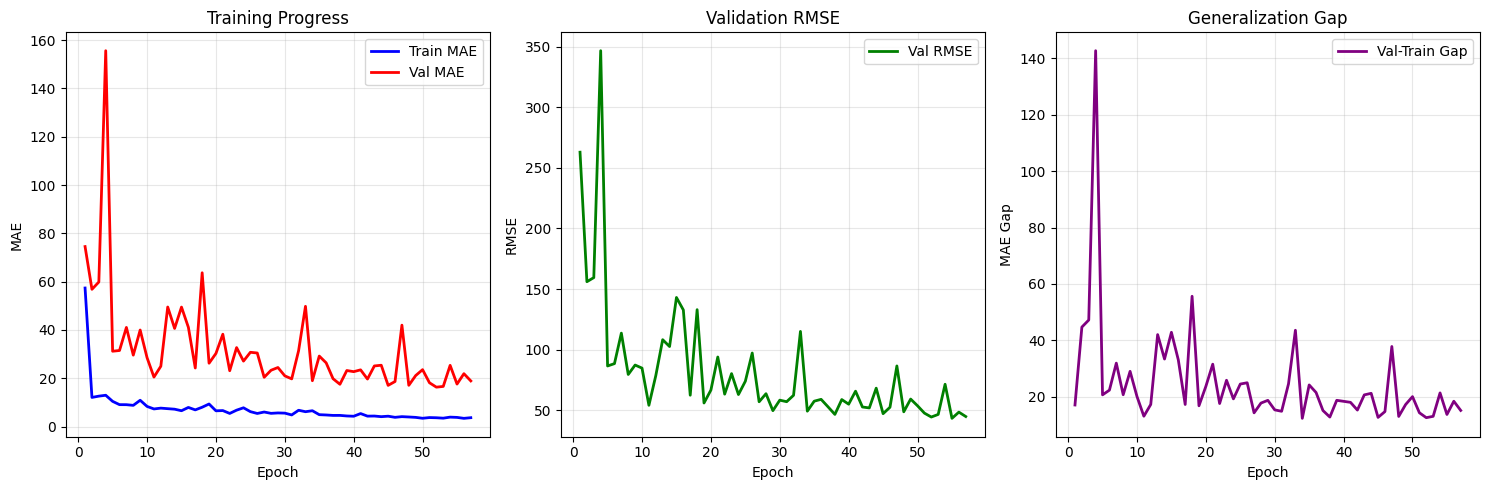

📈 Training Statistics:
   Final Train MAE: 3.691
   Final Val MAE: 18.912
   Final Val RMSE: 44.822
   Best Val MAE: 16.330
   Total Epochs: 57


In [11]:
# Plot training curves
if not len(training_history['epoch']):
    raise Exception("⚠️  No training history available. Please run the training loop first.")

plt.figure(figsize=(15, 5))

# Training and validation MAE
plt.subplot(1, 3, 1)
plt.plot(training_history['epoch'], training_history['train_mae'], 'b-', label='Train MAE', linewidth=2)
plt.plot(training_history['epoch'], training_history['val_mae'], 'r-', label='Val MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation RMSE
plt.subplot(1, 3, 2)
plt.plot(training_history['epoch'], training_history['val_rmse'], 'g-', label='Val RMSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning curve analysis
plt.subplot(1, 3, 3)
train_mae = np.array(training_history['train_mae'])
val_mae = np.array(training_history['val_mae'])
gap = val_mae - train_mae
plt.plot(training_history['epoch'], gap, 'purple', label='Val-Train Gap', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE Gap')
plt.title('Generalization Gap')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("📈 Training Statistics:")
print(f"   Final Train MAE: {training_history['train_mae'][-1]:.3f}")
print(f"   Final Val MAE: {training_history['val_mae'][-1]:.3f}")
print(f"   Final Val RMSE: {training_history['val_rmse'][-1]:.3f}")
print(f"   Best Val MAE: {min(training_history['val_mae']):.3f}")
print(f"   Total Epochs: {len(training_history['epoch'])}")

## Correlation Coefficient

📁 Loading best model checkpoint...
✅ Loaded model from epoch 52 with MAE 16.330

🎯 Final Evaluation - Ground Truth vs Predictions:
1722.jpg            : GT   10.0, Pred    8.4, Error   1.6
915.jpg             : GT  175.0, Pred  137.3, Error  37.7
6.jpg               : GT   10.0, Pred    8.6, Error   1.4
1406.jpg            : GT  658.0, Pred  645.9, Error  12.1
1293.jpg            : GT   29.0, Pred   31.1, Error   2.1
1464.jpg            : GT   53.0, Pred   51.8, Error   1.2
307.jpg             : GT   17.0, Pred   16.4, Error   0.6
1790.jpg            : GT   96.0, Pred   86.2, Error   9.8
418.jpg             : GT  351.0, Pred  274.0, Error  77.0
1720.jpg            : GT  196.0, Pred  121.1, Error  74.9
1891.jpg            : GT    3.0, Pred    3.9, Error   0.9
1249.jpg            : GT   24.0, Pred   17.3, Error   6.7
868.jpg             : GT   20.0, Pred   11.0, Error   9.0
903.jpg             : GT   13.0, Pred    8.9, Error   4.1
610.jpg             : GT    3.0, Pred    4.2, Error   1.2

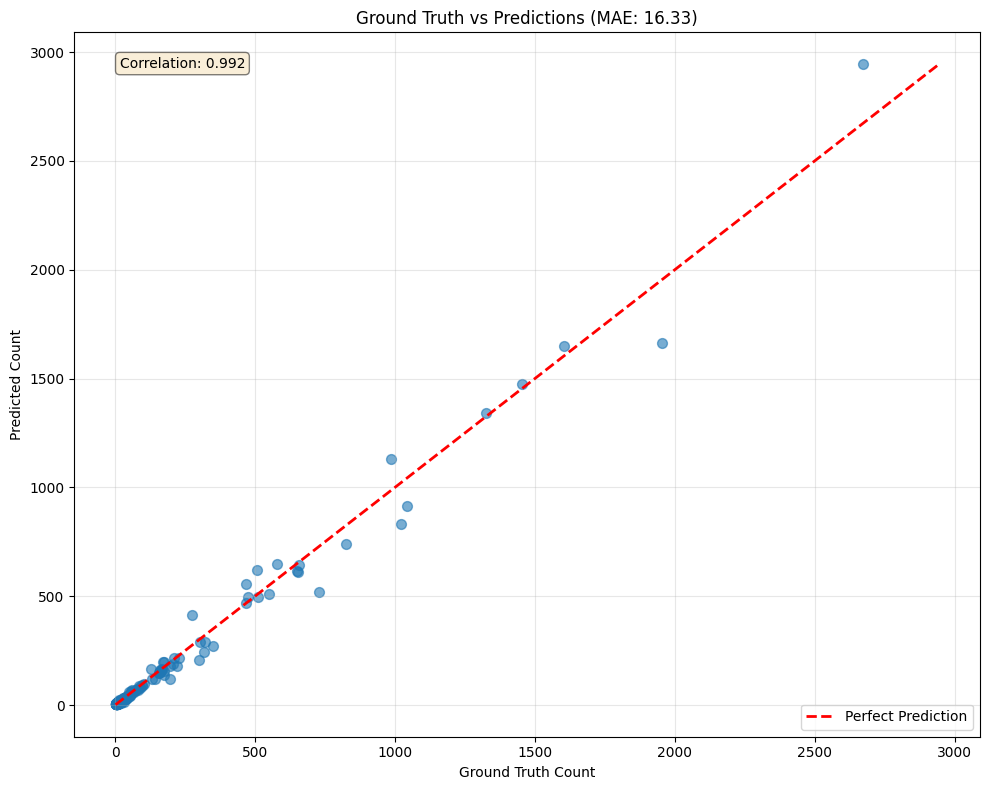


🔗 Correlation coefficient: 0.992


In [12]:
# Load best model for final evaluation
if os.path.exists(config['save_path']):
    print("📁 Loading best model checkpoint...")
    checkpoint = torch.load(config['save_path'], map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model"])
    print(f"✅ Loaded model from epoch {checkpoint['epoch']} with MAE {checkpoint['val_mae']:.3f}")

# Final evaluation with detailed predictions
print("\n🎯 Final Evaluation - Ground Truth vs Predictions:")
print("="*60)

model.eval()
predictions = []
ground_truths = []
image_names = []

with torch.no_grad():
    for batch_idx, (imgs, dens, _) in enumerate(val_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)
        pred = model(imgs)

        pred_cnt_batch = pred.sum((1, 2, 3))
        gt_cnt_batch = dens.sum((1, 2, 3))

        # Store results
        for j in range(pred_cnt_batch.size(0)):
            idx = batch_idx * config['batch_size'] + j
            if idx < len(val_ds.img_paths):
                image_name = os.path.basename(val_ds.img_paths[idx])
                image_names.append(image_name)
                predictions.append(pred_cnt_batch[j].item())
                ground_truths.append(gt_cnt_batch[j].item())

                print(f"{image_name:20s}: GT {gt_cnt_batch[j].item():6.1f}, Pred {pred_cnt_batch[j].item():6.1f}, "
                      f"Error {abs(gt_cnt_batch[j].item() - pred_cnt_batch[j].item()):5.1f}")

# Calculate final metrics
if len(predictions) <= 0:
    raise Exception("⚠️  No validation data processed.")

predictions = np.array(predictions)
ground_truths = np.array(ground_truths)

mae = np.mean(np.abs(predictions - ground_truths))
mse = np.mean((predictions - ground_truths)**2)
rmse = np.sqrt(mse)

print("\n📊 Final Metrics:")
print(f"   MAE:  {mae:.3f}")
print(f"   MSE:  {mse:.3f}")
print(f"   RMSE: {rmse:.3f}")

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(ground_truths, predictions, alpha=0.6, s=50)

# Perfect prediction line
max_val = max(np.max(ground_truths), np.max(predictions))
min_val = min(np.min(ground_truths), np.min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')
plt.title(f'Ground Truth vs Predictions (MAE: {mae:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(ground_truths, predictions)[0, 1]
plt.text(
    0.05,
    0.95,
    f'Correlation: {correlation:.3f}',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.show()

print(f"\n🔗 Correlation coefficient: {correlation:.3f}")

## Density Map Visualization

In [ ]:
# Visualize sample predictions with density maps
def visualize_predictions(
    model,
    dataset,
    device,
    num_samples=3
) -> None:
    """Visualize model predictions with density maps."""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            if i >= len(dataset):
                break

            # Get sample
            img_tensor, gt_density, gt_count = dataset[i]
            img_tensor = img_tensor.unsqueeze(0).to(device)

            # Model prediction
            pred_density = model(img_tensor)

            # Convert to numpy
            img_np = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
            img_np = img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)  # Denormalize
            img_np = np.clip(img_np, 0, 1)

            gt_density_np = gt_density.squeeze().numpy()
            pred_density_np = pred_density.squeeze().cpu().numpy()

            # Calculate counts
            gt_count_val = gt_density_np.sum()
            pred_count_val = pred_density_np.sum()

            # Plot original image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f'Original Image')
            axes[i, 0].axis('off')

            # Plot ground truth density
            im1 = axes[i, 1].imshow(gt_density_np, cmap='jet')
            axes[i, 1].set_title(f'GT Density (Count: {gt_count_val:.1f})')
            axes[i, 1].axis('off')
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

            # Plot predicted density
            im2 = axes[i, 2].imshow(pred_density_np, cmap='jet')
            axes[i, 2].set_title(f'Pred Density (Count: {pred_count_val:.1f})')
            axes[i, 2].axis('off')
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Visualize predictions if validation dataset exists
try:
    print("🎨 Visualizing sample predictions...")
    visualize_predictions(model, val_ds, device, num_samples=20)
except NameError:
    print("⚠️  Validation dataset not available. Please run the data preparation cells first.")

print("\n✅ Training and evaluation complete!")
print(f"🎯 Final model saved at: {config['save_path']}")
print("📊 Training history and visualizations have been generated above.")

# Test Prediction and Generate Submission

In [ ]:
# Create test dataset for inference
class TestDataset(Dataset):
    def __init__(
        self,
        img_dir: str,
        base_size: int = 768
    ) -> None:
        self.img_paths: List[str] = sorted(glob(os.path.join(img_dir, "*.*")))
        self.base_size: int = base_size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, index: int) -> Tuple[Tensor, str]:
        img_path: str = self.img_paths[index]
        img = imread_rgb(img_path)
        canvas, _, _, _ = letterbox(img, target=self.base_size)

        t: Tensor = self.to_tensor(canvas)
        t = self.normalize(t)

        image_name: str = os.path.basename(img_path)
        return t, image_name


# Setup test dataset and loader
test_ds = TestDataset(config['test_dir'], base_size=config['base_size'])
test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

print(f"📦 Test dataset: {len(test_ds)} samples")
print(f"🚀 Test loader: {len(test_loader)} batches")


def generate_submission(
    model: torch.nn.Module,
    test_loader: DataLoader,
    output_file: str = "submission.csv"
) -> pd.DataFrame:
    model.eval()
    predictions: List[int] = []
    image_names: List[str] = []

    with torch.no_grad():
        for images, names in test_loader:
            images = images.to(device)
            pred: Tensor = model(images)
            batch_preds: Tensor = pred.sum((1, 2, 3))

            # Round the result so predicted_count will store as int
            predictions.extend(batch_preds.cpu().numpy().round().astype(int).tolist())
            image_names.extend(names)

    submission_df: pd.DataFrame = pd.DataFrame({
        "image_id": image_names,
        "predicted_count": predictions
    })

    # Sort by image ID (assuming numeric names)
    submission_df["sort_key"] = submission_df["image_id"].apply(
        lambda x: int(os.path.splitext(x)[0])
    )
    submission_df = (
        submission_df
        .sort_values("sort_key")
        .drop("sort_key", axis=1)
        .reset_index(drop=True)
    )

    submission_df.to_csv(output_file, index=False)
    print(f"✅ Submission saved to {output_file}")
    return submission_df


# Generate submission
submission_df = generate_submission(model, test_loader)
print("\n📋 Sample submission:")
submission_df.head(50)

# Saving Model

In [ ]:
# Model Saving for Competition Submission
print("💾 Saving trained model")

# Save complete model (architecture + weights)
model_complete_path = os.path.join(config['save_dir'], 'cognivio_sfcn_model_complete.pth')
torch.save(model, model_complete_path)
print(f"✅ Complete model saved to: {model_complete_path}")

# Save model state dict only
model_weights_path = os.path.join(config['save_dir'], 'cognivio_sfcn_model_weights.pth')
torch.save(model.state_dict(), model_weights_path)
print(f"✅ Model weights saved to: {model_weights_path}")